## 03 Feature Extraction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import fnmatch
import yaml

#### Check GPU availability

In [2]:
from chosen_gpu import get_freer_gpu
device = torch.device(get_freer_gpu()) 
print("Configured device: ", device)

Configured device:  cuda:1


#### File name

In [3]:
# 1-Chaichan_1_2021-04-07-06.24.14
# 2-Dipesh_2_2021-04-07-07.19.01
# 3-Witoon_3_2021-04-07-08.24.44
# 13-Suhel_1_2021-04-09-07.17.43
# 5-Siraphat_2_2021-04-07-11.55.30
# 6-Nuttasit_3_2021-04-07-12.34.46
# 7-Suyogya_1_2021-04-08-08.42.34
# 8-Alok_2_2021-04-08-09.27.31
# 9-Flim_3_2021-04-08-10.21.20
# 10-View_1_2021-04-08-11.03.34
# 11-Pumphat_2_2021-04-08-12.09.09
# 12-Nuclear_3_2021-04-09-06.37.36
# 13-Suhel_1_2021-04-09-07.17.43
# 14-Gon_2_2021-04-09-08.15.26
# 15-Aung_3_2021-04-09-08.57.37
# 16-Rom_1_2021-04-09-10.33.02
# 17-Tawan_2_2021-04-09-11.13.20
# 18-Arthit_3_2021-04-09-11.56.29
# 19-Ankit_1_2021-04-09-12.27.22
# 20-Name_2_2021-04-09-13.54.06
# Missing

### 1. Loading Data

In [4]:
par = sys.argv[1]
file = sys.argv[2]
# visual, imagery
task = sys.argv[3]
model_name = "cnn"
drift = "drift"

X = np.load('../data/preprocessed_np/round2/{par}/{drift}/{file}_{task}_X.npy'.format(par=par,drift = drift,file=file, task=task), allow_pickle=True)
y = np.load('../data/preprocessed_np/round2/{par}/{drift}/{file}_{task}_y.npy'.format(par=par,drift = drift,file=file, task=task), allow_pickle=True)

#### 1.1 Check shape

In [5]:
# [# stim, # electrod, # datapoint]
print(X.shape)
print(y.shape)

(150, 16, 49)
(150,)


#### 1.2 Plot

In [6]:
# ### Plot to see wheter eegs have drift or not
# print(X[100][0].shape)
# fig, ax = plt.subplots(16,1,figsize=(20,50),sharex=True)

# for i in range(data.shape[1]):
#     ax[i].plot(X[100][i])

### 2. Reserve data for Real TEST
- test_size: 0.1
- 10% of data is reserved for the real test --> X_test, y_test
- 90% will be again divided into (train,test,val) --> X_model, y_model

<img src="img/Split.jpg" width=300 height=300 />

#### 2.1 Reserve some data for REAL TEST

In [7]:
from sklearn.model_selection import train_test_split

X_model, X_real_test, y_model, y_real_test = train_test_split( X, y, test_size=0.1, random_state=42, stratify= y)

##### Check if number of classes is equal

In [8]:
def check_split(X1, X2, y1, y2, name1, name2):
    unique1, count1 = np.unique(y1, return_counts=True)
    unique2, count2 = np.unique(y2, return_counts=True)
    
    assert count1[0] == count1[1] == count1[2]
    assert count2[0] == count2[1] == count2[2]
    
    print('='*20,name1,'='*20)
    print(f"Shape of X_{name1}: ", X1.shape)
    print(f"Shape of y_{name1}: ",y1.shape)
    print(f"Classes of y_{name1}: ",unique1)
    print(f"Counts of y_{name1} classes: ",count1)
    print('='*20,name2,'='*20)
    print(f"Shape of X_{name2}: ",X2.shape)
    print(f"Shape of y_{name2}: ",y2.shape)
    print(f"Classes of y_{name2}: ",unique2)
    print(f"Counts of y_{name2} classes: ",count2)

In [9]:
check_split(X_model, X_real_test, y_model, y_real_test,'model','real test')

==================== model ====================
Shape of X_model:  (135, 16, 49)
Shape of y_model:  (135,)
Classes of y_model:  [0 1 2]
Counts of y_model classes:  [45 45 45]
==================== real test ====================
Shape of X_real test:  (15, 16, 49)
Shape of y_real test:  (15,)
Classes of y_real test:  [0 1 2]
Counts of y_real test classes:  [5 5 5]


### 3. Prepare Train Val Test Data 

- 10 can be thought of as totally new eeg records and will be used as the real evaluation of our model.
- For X : Chunking eeg to lengh of 10 data point in each stimuli's eeg
- For y(lebels) : Filled the lebels in y because we chunk X ( 1 stimuli into 6 chunk). We have 500 labels before but now we need 500 x 6 = 3000 labels

#### 3.1 Chunking

In [10]:
import sys
np.set_printoptions(threshold=sys.maxsize)

def chunk_data(data, size):
    data_keep = data.shape[2] - (data.shape[2]%size)
    #print(f'{data.shape}')
    data = data[:,:,:data_keep]
    #print(f'{data.shape}')
    #print(data[0,0,:20])
    data = data.reshape(-1,data.shape[1],data.shape[2]//size,size)
    #print(f'{data.shape}')
    #print(data[0,0,:2,:])
    data = np.transpose(data, (0, 2, 1, 3)  )
    #print(f'{data.shape}')
    #print(data[0,:2,0,:])
    return data

def filled_y(y, chunk_num):
    yy = np.array([[i] *chunk_num for i in  y ]).ravel()
    return yy

In [11]:
chunk_size = 10

print('=================== X ==================')
print(f'Oringinal X shape {X_model.shape}')
X = chunk_data(X_model, chunk_size)
print(f'Chunked X : {X.shape}') # (#stim, #chunks, #electrodes, #datapoint per chunk)
chunk_per_stim = X.shape[1]
X = X.reshape(-1,16,chunk_size)
print(f'Reshape X to : {X.shape}')
print('=================== y ==================')
print(f'Shape of y : {y_model.shape}')
y_filled = filled_y(y_model, chunk_per_stim)
y = y_filled
print(f'Shape of new y : {y.shape}')

=================== X ==================
Oringinal X shape (135, 16, 49)
Chunked X : (135, 4, 16, 10)
Reshape X to : (540, 16, 10)
=================== y ==================
Shape of y : (135,)
Shape of new y : (540,)


#### 3.2 Train Test Val Split and Prepare X and y in correct shape

- For X, pytorch (if set batch_first) LSTM requires to be (batch, seq_len, features).  Thus, for us, it should be (100, 75, 16).
- For y, nothing is special
- So let's convert our numpy to pytorch, and then reshape using view

##### 3.2.1 Train Test Val Split

In [12]:
X_train, X_val_test, y_train, y_val_test = train_test_split( X, y, test_size=0.3, random_state=42, stratify= y)
check_split(X_train, X_val_test, y_train, y_val_test,'train','val_test')

==================== train ====================
Shape of X_train:  (378, 16, 10)
Shape of y_train:  (378,)
Classes of y_train:  [0 1 2]
Counts of y_train classes:  [126 126 126]
==================== val_test ====================
Shape of X_val_test:  (162, 16, 10)
Shape of y_val_test:  (162,)
Classes of y_val_test:  [0 1 2]
Counts of y_val_test classes:  [54 54 54]


In [13]:
X_val, X_test, y_val, y_test = train_test_split( X_val_test, y_val_test, test_size=0.33, random_state=42, stratify= y_val_test)
check_split(X_val, X_test, y_val, y_test ,'val','test')

==================== val ====================
Shape of X_val:  (108, 16, 10)
Shape of y_val:  (108,)
Classes of y_val:  [0 1 2]
Counts of y_val classes:  [36 36 36]
==================== test ====================
Shape of X_test:  (54, 16, 10)
Shape of y_test:  (54,)
Classes of y_test:  [0 1 2]
Counts of y_test classes:  [18 18 18]


##### 3.2.2 Convert to torch

In [14]:
def check_torch_shape(torch_X, torch_y, name):
    print('='*20,name,'='*20)
    print(f"Shape of torch_X_{name}: ",torch_X.shape)
    print(f"Shape of torch_y_{name}: ",torch_y.shape)    

In [15]:
torch_X_train = torch.from_numpy(X_train)
torch_y_train = torch.from_numpy(y_train)
check_torch_shape(torch_X_train,torch_X_train,'train')

torch_X_val = torch.from_numpy(X_val)
torch_y_val = torch.from_numpy(y_val)
check_torch_shape(torch_X_val,torch_y_val,'val')

torch_X_test = torch.from_numpy(X_test)
torch_y_test = torch.from_numpy(y_test)
check_torch_shape(torch_X_test,torch_y_test,'test')

==================== train ====================
Shape of torch_X_train:  torch.Size([378, 16, 10])
Shape of torch_y_train:  torch.Size([378, 16, 10])
==================== val ====================
Shape of torch_X_val:  torch.Size([108, 16, 10])
Shape of torch_y_val:  torch.Size([108])
==================== test ====================
Shape of torch_X_test:  torch.Size([54, 16, 10])
Shape of torch_y_test:  torch.Size([54])


##### 3.2.3 Reshape

CNN requires the input shape as (batch, channel, height, width)

In [16]:
torch_X_train_reshaped = torch_X_train.reshape(torch_X_train.shape[0],torch_X_train.shape[1],1,torch_X_train.shape[2])
print("Converted torch_X_train to ", torch_X_train_reshaped.size())

torch_X_val_reshaped = torch_X_val.reshape(torch_X_val.shape[0],torch_X_val.shape[1],1,torch_X_val.shape[2])
print("Converted torch_X_val to ", torch_X_val_reshaped.size())

torch_X_test_reshaped = torch_X_test.reshape(torch_X_test.shape[0],torch_X_test.shape[1],1,torch_X_test.shape[2])
print("Converted torch_X_test to ", torch_X_test_reshaped.size())


Converted torch_X_train to  torch.Size([378, 16, 1, 10])
Converted torch_X_val to  torch.Size([108, 16, 1, 10])
Converted torch_X_test to  torch.Size([54, 16, 1, 10])


### 4. Dataset and DataLoader

In [17]:
from torch.utils.data import TensorDataset

BATCH_SIZE = 128 #keeping it binary so it fits GPU

#Train set loader
train_dataset = TensorDataset(torch_X_train_reshaped, torch_y_train)
train_iterator = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)
#Val set loader
val_dataset = TensorDataset(torch_X_val_reshaped, torch_y_val)
valid_iterator = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)
#Test set loader
test_dataset = TensorDataset(torch_X_test_reshaped, torch_y_test)
test_iterator = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)


### 5. Training for Feature Extraction 


#### 5.1 Define functions for calculating time, plotting and counting model params

In [18]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def do_plot(train_losses, valid_losses):
    plt.figure(figsize=(25,5))
#     clear_output(wait=True)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.title('Train and Val loss')
    plt.legend()
    plt.show()
    
#Count the parameters for writing papers
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#### 5.2 Define model parameters
- Count model parameters
- optimizer
- loss function
- GPU

In [19]:
from models import EEGEncoder

In [20]:
model_EEGEncoder = EEGEncoder()
model_EEGEncoder = model_EEGEncoder.float() #define precision as float to reduce running time
models = [model_EEGEncoder]

for model in models:
    print(f'The model {type(model).__name__} has {count_parameters(model):,} trainable parameters')# Train the model


The model EEGEncoder has 150,627 trainable parameters


#### 5.3 Train the model

In [21]:
from train import train
from evaluate import evaluate

In [22]:
import torch.optim as optim

best_valid_loss = float('inf')
train_losses    = []
valid_losses    = []

learning_rate = 0.0001
N_EPOCHS      = 1000          ## best is 10k
criterion     = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr=learning_rate)


for model in models:
    model = model.to(device)
criterion = criterion.to(device)


Epoch: 1000/1000  |	Train Loss: 0.01658  | Train Acc: 99.47%  |	 Val. Loss: 0.82760  | Val. Acc: 81.48%


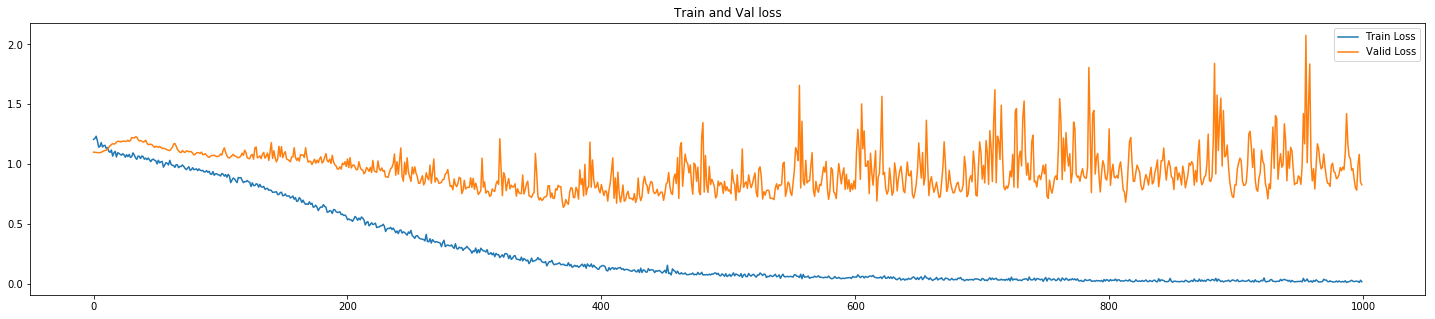

In [23]:
model.is_debug = False
iteration = 0
classes = np.array(('Red', 'Green', 'Blue'))
for i, model in enumerate(models):
    print(f"Training {type(model).__name__}")
    
    start_time = time.time()

    for epoch in range(N_EPOCHS):
        start_time = time.time()

        train_loss, train_acc, train_predicted    = train(model, train_iterator, optimizer, criterion, device)
        valid_loss, valid_acc, valid_predicted, _ = evaluate(model, valid_iterator, criterion, classes, device)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        iteration     += 1
        
        if (epoch+1) % 50 == 0:
            clear_output(wait=True)
            print(f'Epoch: {epoch+1:02}/{N_EPOCHS}  |',end='')
            print(f'\tTrain Loss: {train_loss:.5f}  | Train Acc: {train_acc:.2f}%  |', end='')
            print(f'\t Val. Loss: {valid_loss:.5f}  | Val. Acc: {valid_acc:.2f}%')
            do_plot(train_losses, valid_losses)
          

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            print("Model:{} saved.".format(type(model).__name__))
            torch.save(model.state_dict(), "../model/feature_extraction/round2/{par}/{model_name}/{drift}/EEG_ENCODER_{task}.pt.tar".format(par=par, model_name=model_name,drift=drift,task=task))
            best_model_index = i

### 6. Evaluation [Test set]
using test set

In [24]:
def squeeze_to_list(_tmp):
    from functools import reduce
    import operator
    xx = [ i.cpu().detach().numpy().ravel().tolist() for i in _tmp]
    xx = reduce(operator.concat, xx)
    return xx

#### Define classes

In [25]:
classes = np.array(('Red', 'Green', 'Blue'))
model = EEGEncoder()
model = model.float()
model = model.to(device)
model.load_state_dict(torch.load('../model/feature_extraction/round2/{par}/{model_name}/{drift}/EEG_ENCODER_{task}.pt.tar'.format(par=par,model_name=model_name,drift=drift,task=task)))

<All keys matched successfully>

In [26]:
test_loss, test_acc , predicted, actual_labels, acc_class_test = evaluate(model, test_iterator, criterion, classes, device, test = True)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')
print("---------------")
print(" (Actual y , Predicted y)")

y_test_t = squeeze_to_list(actual_labels)
y_hat_test_t = squeeze_to_list(predicted)

out_test = zip(y_test_t, y_hat_test_t)

print(list(out_test))

Accuracy of   Red : 88 %
Accuracy of Green : 88 %
Accuracy of  Blue : 83 %
Test Loss: 0.438 | Test Acc: 87.04%
---------------
 (Actual y , Predicted y)
[(1, 1), (0, 1), (1, 1), (2, 2), (1, 1), (2, 2), (1, 1), (1, 1), (2, 2), (2, 2), (1, 0), (0, 2), (0, 0), (0, 0), (1, 1), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (0, 0), (1, 1), (1, 1), (0, 0), (1, 1), (2, 2), (0, 0), (0, 0), (1, 0), (0, 0), (2, 1), (0, 0), (0, 0), (2, 2), (0, 0), (1, 1), (1, 1), (0, 0), (1, 1), (1, 1), (1, 1), (2, 2), (0, 0), (0, 0), (2, 2), (0, 0), (2, 0), (2, 2), (2, 2), (2, 0), (0, 0), (1, 1), (0, 0), (1, 1)]


### 7. Evaluation [Real Test]

In [27]:
# print(x_test)
X_real_test = chunk_data(X_real_test, chunk_size)
chunk_per_stim = X_real_test.shape[1]
X_real_test = X_real_test.reshape(-1,16,chunk_size)
y_filled_real_test = filled_y(y_real_test, chunk_per_stim)

print("Chucked X_test: ",X_real_test.shape )
print("y_filled_test: ",y_filled_real_test.shape )

Chucked X_test:  (60, 16, 10)
y_filled_test:  (60,)


In [28]:
torch_X_real_test = torch.from_numpy(X_real_test)
torch_y_real_test = torch.from_numpy(y_filled_real_test)
check_torch_shape(torch_X_real_test,torch_y_real_test,'test')

print("Shape of torch_X: ",torch_X_real_test.shape)
print("Shape of torch_y: ",torch_y_real_test.shape)

==================== test ====================
Shape of torch_X_test:  torch.Size([60, 16, 10])
Shape of torch_y_test:  torch.Size([60])
Shape of torch_X:  torch.Size([60, 16, 10])
Shape of torch_y:  torch.Size([60])


In [29]:
torch_X_real_test_reshaped = torch_X_real_test.reshape(torch_X_real_test.shape[0],torch_X_real_test.shape[1],1,torch_X_real_test.shape[2])
print("Converted X to ", torch_X_real_test_reshaped.size())

Converted X to  torch.Size([60, 16, 1, 10])


In [30]:
real_test_dataset = TensorDataset(torch_X_real_test_reshaped, torch_y_real_test)
#Test set loader
real_test_iterator = torch.utils.data.DataLoader(dataset=real_test_dataset, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)

In [31]:
model = EEGEncoder()
model = model.float()
model = model.to(device)
model.load_state_dict(torch.load('../model/feature_extraction/round2/{par}/{model_name}/{drift}/EEG_ENCODER_{task}.pt.tar'.format(par=par,model_name=model_name,drift=drift,task=task)))

<All keys matched successfully>

In [32]:
test_loss, real_test_acc , predicted, actual_labels, acc_class_real_test = evaluate(model, real_test_iterator, criterion, classes, device, test=True)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {real_test_acc:.2f}%')
print("---------------")
print(" (Actual y , Predicted y)")

y_test_rt    = squeeze_to_list(actual_labels)
y_hat_test_rt = squeeze_to_list(predicted)

out_real_test = zip(y_test_rt, y_hat_test_rt)

print(list(out_real_test))

Accuracy of   Red : 50 %
Accuracy of Green : 20 %
Accuracy of  Blue : 30 %
Test Loss: 2.292 | Test Acc: 33.33%
---------------
 (Actual y , Predicted y)
[(1, 1), (1, 2), (0, 0), (2, 0), (0, 1), (2, 2), (2, 1), (0, 0), (1, 2), (0, 1), (1, 2), (0, 1), (1, 0), (0, 1), (2, 1), (2, 1), (2, 0), (1, 2), (1, 0), (0, 0), (2, 2), (2, 0), (0, 0), (2, 0), (1, 0), (2, 1), (2, 1), (2, 0), (1, 2), (0, 2), (0, 1), (2, 0), (2, 2), (1, 2), (1, 1), (2, 1), (0, 0), (2, 2), (1, 0), (0, 2), (0, 0), (2, 2), (0, 0), (0, 0), (2, 2), (1, 2), (0, 1), (1, 0), (1, 1), (0, 1), (0, 0), (1, 2), (2, 1), (1, 0), (0, 0), (1, 0), (1, 2), (1, 1), (0, 1), (2, 0)]


### 8. Extracted Features

- train + val

In [33]:
X_train_val = np.concatenate((X_train,X_val))
y_train_val = np.concatenate((y_train,y_val))

print(X_train_val.shape)
print(y_train_val.shape)

(486, 16, 10)
(486,)


In [34]:
torch_X_train_val = torch.from_numpy(X_train_val)
torch_y_train_val = torch.from_numpy(y_train_val)
check_torch_shape(torch_X_train_val,torch_y_train_val,'train_val')

torch_X_train_val_reshaped = torch_X_train_val.reshape(torch_X_train_val.shape[0],torch_X_train_val.shape[1],1,torch_X_train_val.shape[2])
print("Converted X to ", torch_X_train_val_reshaped.size())

==================== train_val ====================
Shape of torch_X_train_val:  torch.Size([486, 16, 10])
Shape of torch_y_train_val:  torch.Size([486])
Converted X to  torch.Size([486, 16, 1, 10])


In [35]:
# save extracted features
eeg_encode = model_EEGEncoder.get_latent(torch_X_train_val_reshaped.to(device).float())
eeg_extracted_features = eeg_encode.detach().cpu().numpy()

### 9. SAVE

In [36]:
# Save Real Test
np.save("../data/participants/{par}/{task}/X_real_test".format(par=par,task=task),X_real_test)
np.save("../data/participants/{par}/{task}/y_real_test".format(par=par,task=task),y_filled_real_test)

# Save Train
np.save("../data/participants/{par}/{task}/X_train".format(par=par,task=task),X_train)
np.save("../data/participants/{par}/{task}/y_train".format(par=par,task=task),y_train)

# Save Test
np.save("../data/participants/{par}/{task}/X_test".format(par=par,task=task),X_test)
np.save("../data/participants/{par}/{task}/y_test".format(par=par,task=task),y_test)

# Save Val
np.save("../data/participants/{par}/{task}/X_val".format(par=par,task=task),X_val)
np.save("../data/participants/{par}/{task}/y_val".format(par=par,task=task),y_val)

# Save Extracted Features
np.save('../data/participants/{par}/{task}/extracted_features_X'.format(par=par,task=task), eeg_extracted_features )
np.save('../data/participants/{par}/{task}/extracted_features_y'.format(par=par,task=task), y_train_val)

### 10. Results

In [37]:
print("Train Acc: ",train_acc)
print("Valid Acc: ",valid_acc)
print("Test Acc: ",test_acc)
print("Real test Acc: ",real_test_acc)
print('='*30)
print("Acc per class for test")
for v,k in acc_class_test.items():
    print(f"{v}: {k}")

Train Acc:  99.47089947089947
Valid Acc:  81.48148148148148
Test Acc:  87.03703703703704
Acc per class for test
Red: [88.88888888888889]
Green: [88.88888888888889]
Blue: [83.33333333333333]


In [38]:
print('='*30)
print("Acc per class for test")
for v,k in acc_class_test.items():
    print(f"{v}: {k}")
    
print('='*30)
print("Acc per class for real test")
for v,k in acc_class_real_test.items():
    print(f"{v}: {k}")

Real test Acc:  33.33333333333333
Acc per class for real test
Red: [50.0]
Green: [20.0]
Blue: [30.0]


In [39]:
# from sklearn.metrics import classification_report
# target_names = ['R', 'G', 'B']
# print('='*27,'TEST','='*27)
# print(classification_report(y_test_, y_hat_test_, target_names=target_names, digits=4))
# print('='*25,'REAL TEST','='*25)
# print(classification_report(y_test, y_hat_test, target_names=target_names, digits=4))